In [130]:
path = 'test.txt'

# Initializing error messages list
error_messages = []

with open(path) as error_log:
    for line in error_log:
        # Removing the end of line character
        line = line.replace('\n', '')
        error_messages.append(line)

In [131]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()


In [139]:
from collections import Counter
 
messages_list = []
edges_list = []
nodes_list = []

for message in error_messages:
    message = message.split()
    # add the messages as nodes in the graph
    nodes_list += message
    
    # Preprocessing the tokens list to egde tuples (a, b, c) -> (a,b), (b,c)
    edges = []
    for i in range(0, len(message), 2):
      if i < len(message)-1:
        edges.append((message[i], message[i+1]))
      if i < len(message)-2:
        edges.append((message[i+1], message[i+2]))
    messages_list.append(message)
    edges_list += edges

# Adding edges to the graph with their respective weights
G.add_edges_from(edges_list)
# Adding nodes to the graph with their respective weights
G.add_nodes_from(nodes_list)

# Count number of occurences for edges
edges_weights = dict(Counter(edges_list))
# Count number of occurences for nodes
nodes_weights = dict(Counter(nodes_list))

# Adding weight information to the graph
nx.set_edge_attributes(G, values = edges_weights, name = 'weight')
nx.set_node_attributes(G, values = nodes_weights, name = 'weight')



In [140]:
# identify variable nodes in graph
threshold = 3
variable_nodes = set()
for node, data in G.nodes(data=True):
    if data['weight'] <= threshold:
        variable_nodes.add(node)

# identify variable edges in graph
variable_edges = set()
for node1, node2 in G.edges:
    if node1 in variable_nodes or node2 in variable_nodes:
        variable_edges.add((node1, node2))

# add dictionary edge tracker where the before and after nodes are stored
edges_layout = {}

# create a variable node
variable_count = 0
# variable tracker
var_tracker = {}
# Initialise variable nodes layout tracker# variable tracker
for count in range(0,len(variable_nodes)):
    # Declare variable node
    variable_node = 'var_' + str(variable_count)
    # adding the variable_node to the dictionary edges_layout
    if variable_node not in edges_layout:
        keys = ['before', 'after']
        edges_layout[variable_node] = {key: [] for key in keys}
        edges_layout[variable_node]['available'] = True
        var_tracker[variable_node] = []
    variable_count += 1

KeyError: 'weight'

In [141]:
def allocate_variable_layout(before, after, dictionary):
    variable_node = None
    # Find next available variable
    for key,value in dictionary.items():
        # Once found, change its availability flag
        if value['available'] == True:
            variable_node = key
            value['before'] = before
            value['after'] = after
            value['occurence'] = 1 
            value['available'] = False
            break
    # Return the dictionary
    return key, dictionary

def delete_empty_layouts(dictionary):
    keys = []
    # Find unalocated nodes
    for key,value in dictionary.items():
        if value['available'] == True:
            keys.append(key)
            continue
    # Proceed to delete those
    for key in keys:
        dictionary.pop(key, None)
    # Return the dictionary
    return dictionary

def search_layouts(before, after, dictionary):
    for key,value in dictionary.items():
        if value['before'] == before and value['after'] == after:
            return key
    return 'LAYOUT NOT FOUND'
        
def replace_node_by_var_list(node, variable, nodes_list):
    new_list = []
    for element in nodes_list:
        if element == node:
            new_list.append(variable)
        else:
            new_list.append(element)
    return new_list

def replace_node_by_var_tuples(node, variable, tuples_list):
    new_list = []
    for node1, node2 in tuples_list:
        if node == node1:
            new_list.append(variable, node2)
        elif node == node2:
            new_list.append(node1, variable)
        else:
            new_list.append(node1, node2)
    return new_list

def update_dictionary(node, variable, dictionary):
    for key, value in dictionary.items():
        value['before'] = replace_node_by_var_list(node, variable, value['before'])
        value['after'] = replace_node_by_var_list(node, variable, value['after'])
    return dictionary
    

In [142]:
# Once layouts are captured, it is time to create the new edge list that needs to be modified
edges_to_remove = variable_edges
nodes_to_remove = variable_nodes
edges_to_add = []
nodes_to_add = []

for node in variable_nodes:
    before = []
    after = []
    # Finding tuples where the variable node is defined
    tuple_result = filter(lambda x: x[0] == node or x[1] == node, G.edges)
        
    for tuple_node_1, tuple_node_2 in tuple_result:
        if node == tuple_node_1:
            after.append(tuple_node_2)
        elif node == tuple_node_2:
            before.append(tuple_node_1)
    # Search for the layout
    variable = search_layouts(before, after, edges_layout)
    # If the layout does not exist, return
    if variable == 'LAYOUT NOT FOUND':
        variable, edges_layout = allocate_variable_layout(before, after, edges_layout)
    
    var_tracker[variable].append(node)
    # Creating the edges to be added
    for node_after in after:
        edges_to_add.append((variable, node_after))
    for node_before in before:
        edges_to_add.append((node_before, variable))
    
    # Updating the dictionary layout
    edges_layout = update_dictionary(node, variable, edges_layout)
# Removing unnecessary keys
edges_layout = delete_empty_layouts(edges_layout)
# Assigning the nodes to be added list
nodes_to_add = list(edges_layout.keys())

In [152]:
for node in G:
    color_map = []
    if 'var_' in node:
        color_map.append('blue')

var_0
var_1
var_2
var_3
var_4
var_5
var_6
var_7
var_8
var_9
var_10
var_11
var_12
var_13
var_14
var_15
var_16
var_17
var_18
var_19
var_20
var_21
var_22
var_23
var_24
var_25
var_26
var_27
var_28


In [144]:
G.remove_edges_from(edges_to_remove)
G.remove_nodes_from(nodes_to_remove)
G.add_nodes_from(nodes_to_add)
G.add_edges_from(edges_to_add)

remove = [node for node,degree in dict(G.degree()).items() if degree == 0]
G.remove_nodes_from(remove)

/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 27 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 27 missing from current font.
  font.set_text(s, 0, flags=flags)


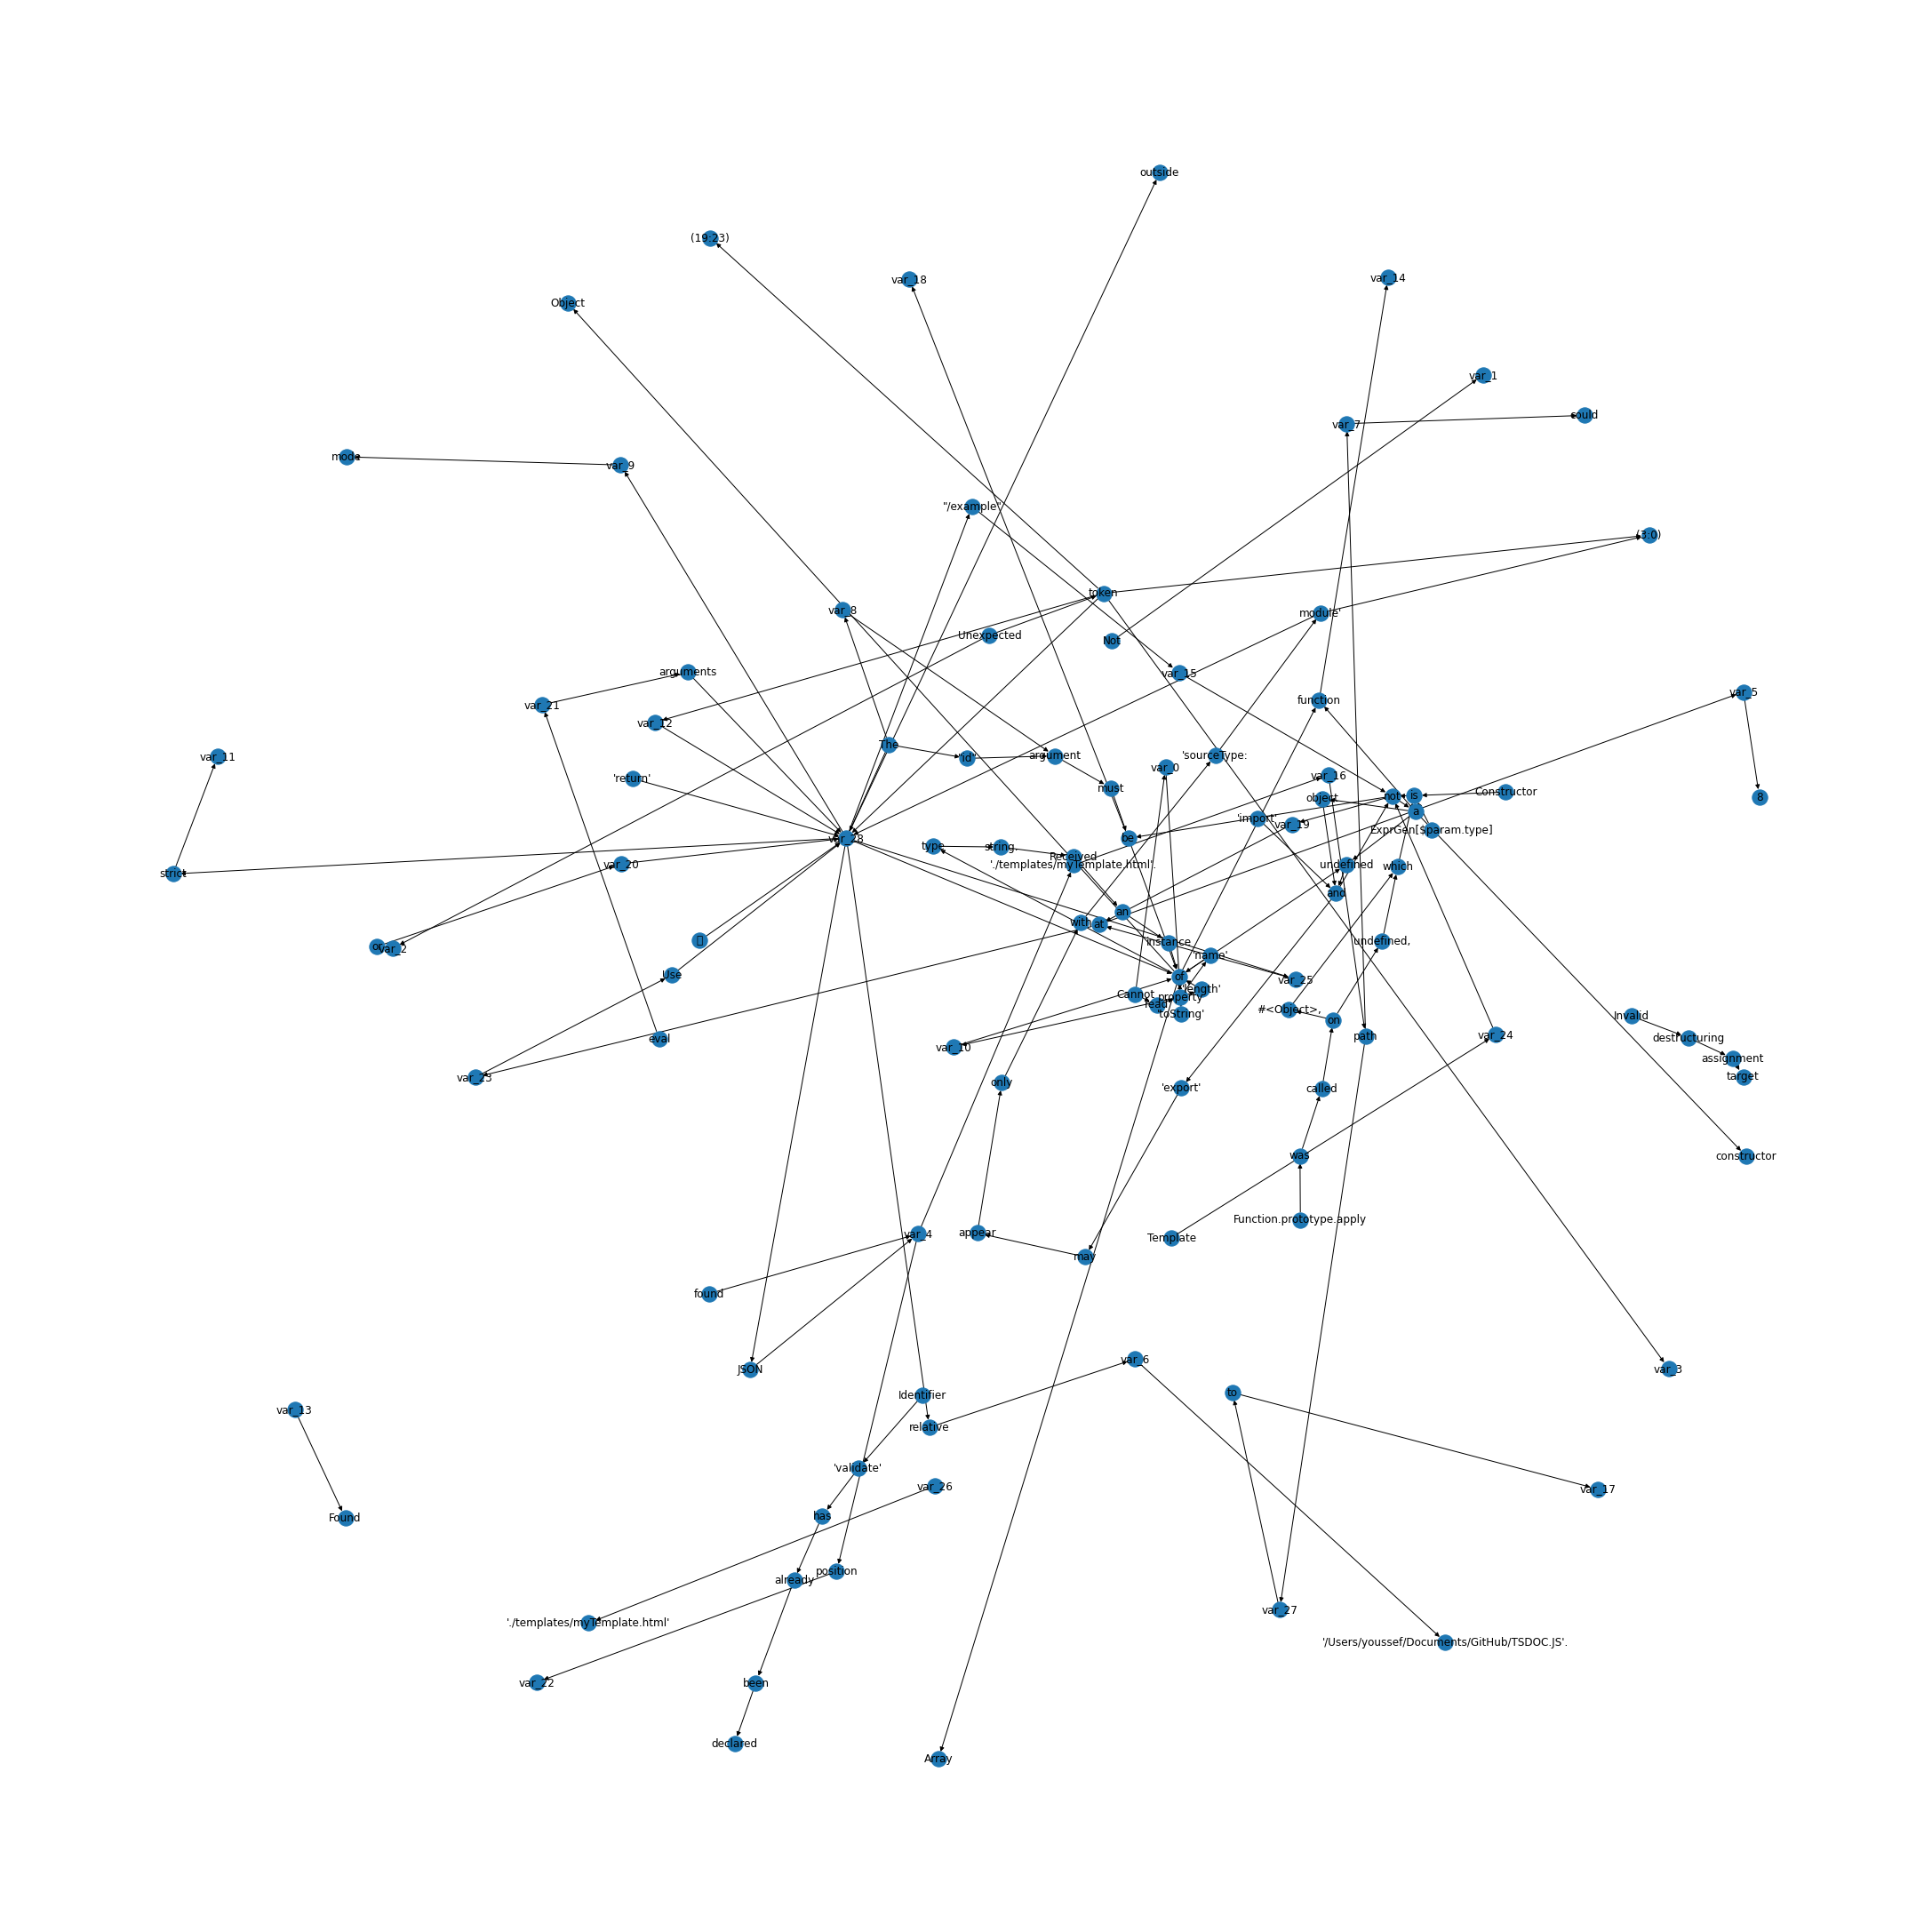

In [145]:
pos_spaced=nx.fruchterman_reingold_layout(G, k=0.5, iterations=100)

#elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
#esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

#weights = [G[u][v]['weight'] for u,v in G.edges]
plt.figure(figsize=(30,30))

nx.draw(G, pos=pos_spaced, with_labels = True)
#labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx_edge_labels(G,pos=pos_spaced,edge_labels=labels)


In [ ]:
nx.draw(G, with_labels = True)
plt.savefig("simple_path.png") # save as png
plt.show()

In [ ]:
pos_spaced=nx.fruchterman_reingold_layout(G, k=0.5, iterations=100)

plt.figure(figsize=(30,30))
nx.draw(G, pos=pos,
        with_labels=True,
        node_color='lightgreen')

In [ ]:
# Removing duplicates from error messages
print("Length before removing duplicates:" + str(len(error_messages)))
error_messages = list(dict.fromkeys(error_messages))
print("Length after removing duplicates:" + str(len(error_messages)))

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout


def construct_graph(error_messages):
  """ This function constructs a networkx graph from error messages tokens
  """
  graph = nx.DiGraph()
  messages_list = []
  edges_list = []

  for message in error_messages:
      message = message.split()
      # add the messages as nodes in the graph
      graph.add_nodes_from(message)
      
      # Preprocessing the tokens list to egde tuples (a, b, c) -> (a,b), (b,c)
      edges = []
      for i in range(0, len(message), 2):
        if i < len(message)-1:
          edges.append((message[i], message[i+1]))
        if i < len(message)-2:
          edges.append((message[i+1], message[i+2]))
      messages_list.append(message)
      edges_list += edges

  # Adding edges to the graph with their respective weights
  graph.add_edges_from(edges_list)

  # Count number of occurences for edges
  edges_weights = dict(Counter(edges_list))

  # Adding weight information to the graph
  nx.set_edge_attributes(graph, values = edges_weights, name = 'weight')

  return graph

def draw_graph(graph, title):
  # Specifying graph layout
  pos = graphviz_layout(graph, prog='dot')
  # Setting figure size
  fig = plt.figure(figsize=(15,15))
  ax = plt.subplot(111)
  # Set title
  ax.set_title(title, fontsize=10)

  # extracting weights information
  edges = graph.edges()
  weights = [graph[u][v]['weight']/20 for u,v in edges]

  nx.draw(graph,
          pos=pos,
          with_labels=True,
          node_color='lightgreen',
          width=weights,
          ax=ax)
  plt.tight_layout()
  plt.savefig(title+".png", format="PNG")
  plt.show()
    
  #edge_labels = nx.get_edge_attributes(graph,'weight')
  # nx.draw_networkx_edge_labels(graph, pos, edge_labels)
  

In [ ]:
!apt-get install graphviz libgraphviz-dev pkg-config python-pip

In [ ]:
!pip install pygraphviz --install-option="--include-path=/usr/include/graphviz" --install-option="--library-path=/usr/lib/graphviz/" 

In [ ]:
from itertools import groupby
from operator import itemgetter

error_messages_grouped = groupby(sorted(error_messages), key = lambda x: x.split()[0])

for first_word, messages in error_messages_grouped:
    graph = construct_graph(messages)
    print(graph)
    if graph is not None:
      title = first_word + " error graph"
      draw_graph(graph, first_word)
    else:
      print("The graph returned is none")


In [ ]:
def increment_dict_count(dictionary, key):
  if key in dictionary:
    dictionary[key] += 1
  else:
    dictionary[key] = 1
  return dictionary

# Find nodes with single weights
variable_nodes_edges = []

# initializing a node count dictionary, the idea is to find which nodes will be considered as variable
node_occurence = {}

# Computing node occurence
for node1, node2, data in G.edges(data=True):
  if data['weight'] == 1:
    variable_nodes_edges.append((node1,node2))
    node_occurence = increment_dict_count(node_occurence, node1)
    node_occurence = increment_dict_count(node_occurence, node2)

# replace nodes that only occure twice or less by a <v> node
# Some nodes have appear twice because they are in the middle of the graph 
# Similarly, other nodes appear only once because they might be at the extremeties of the graph
#
# This list stores variable nodes based on an occurence threshold
variable_nodes = set()
# Setting a treshhold variable
threshold = 3
for node1, node2 in variable_nodes_edges:
  # First pass only replace the first node, do the same on a second pass while keeping track of the variable nodes
  if node_occurence[node1] < threshold and node_occurence[node2] < threshold:
    variable_nodes.add(node1)
    variable_nodes.add(node2)
    continue
  if node_occurence[node1] < threshold:
    variable_nodes.add(node1)
    continue
  if node_occurence[node2] < threshold:
    variable_nodes.add(node2)
    continue

